# Building an AI Pipeline for Image Segmentation and Object Analysis

# 1. Image Segmentation

#### Initialize Model , and Pre-process image

C:\Users\Rahul\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Rahul\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


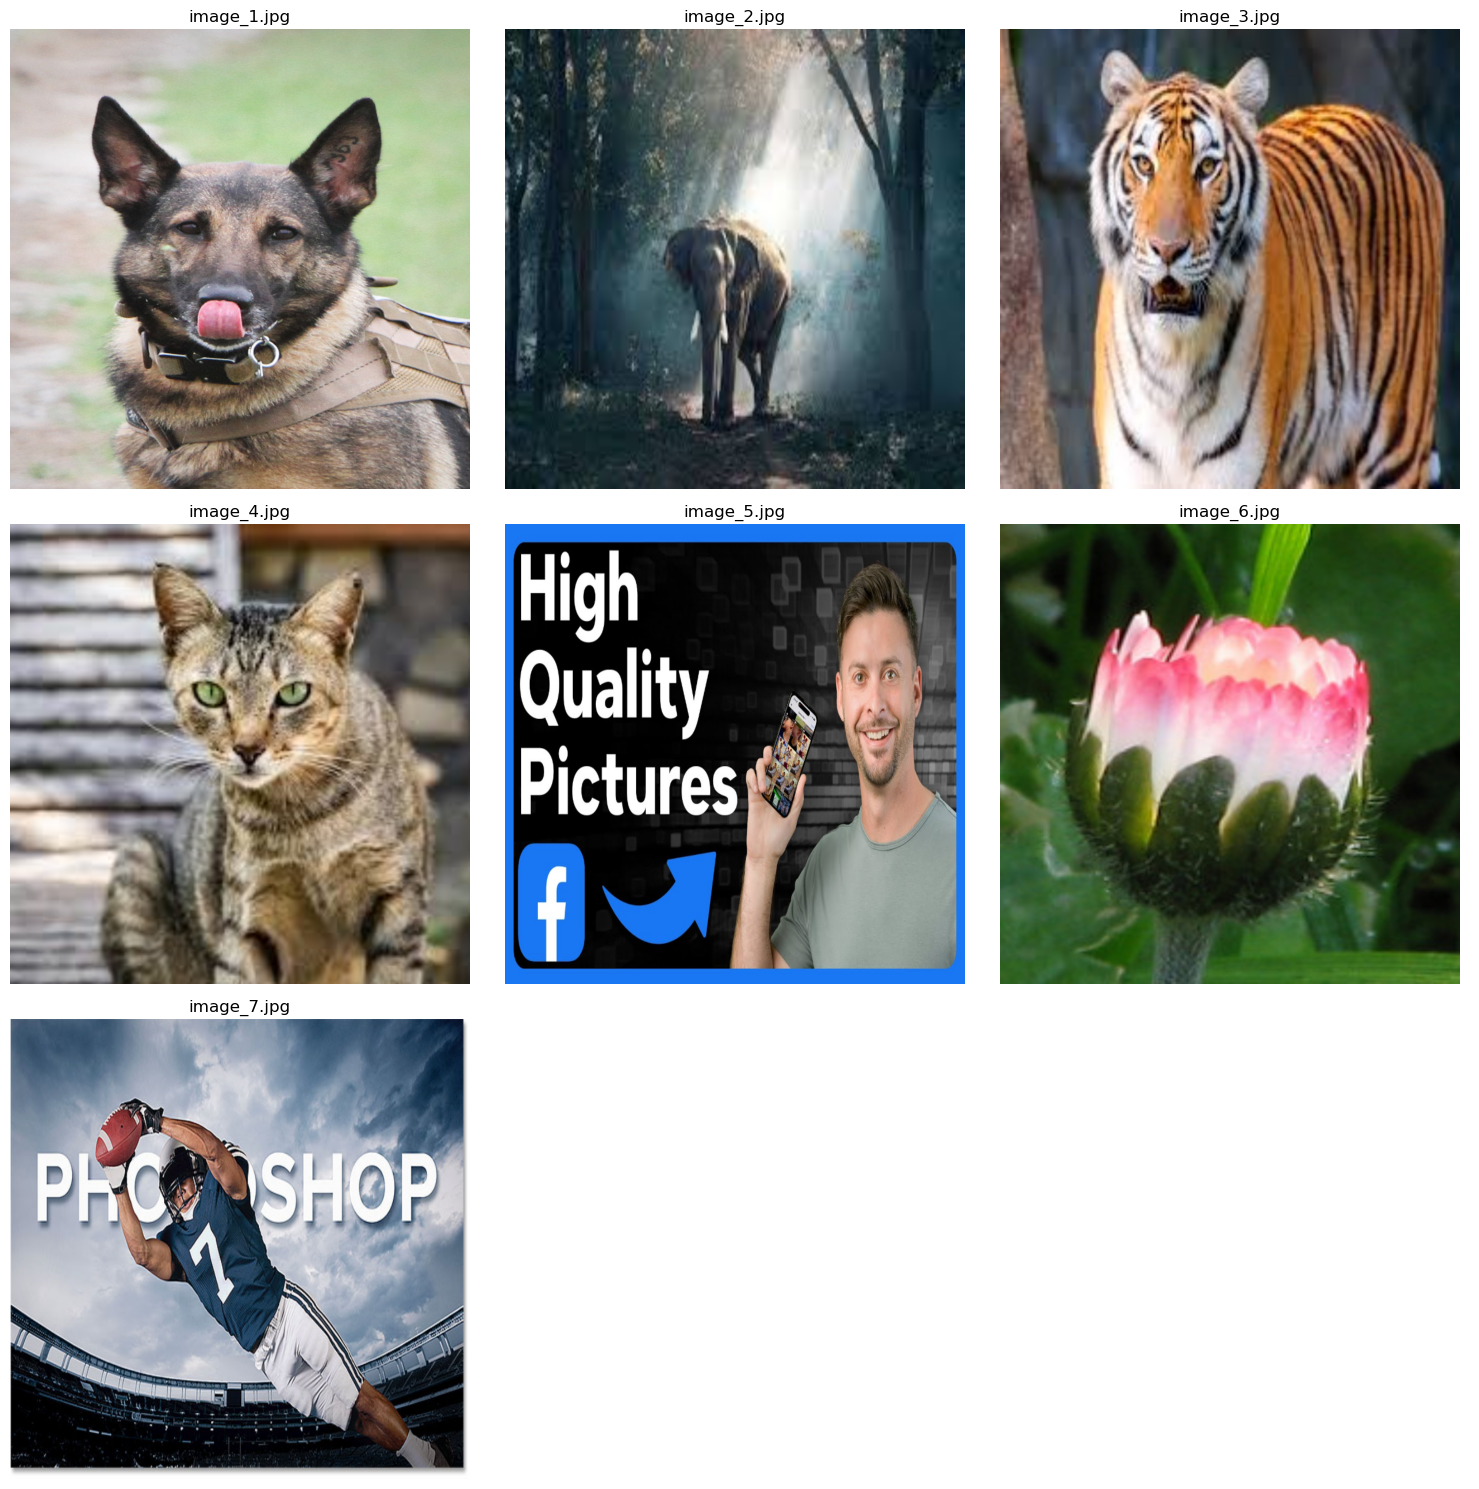

In [15]:
# Loading the required libraries
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.transforms import functional as F

# Define directories
input_images_dir = 'data/input_images'
output_images_dir = 'data/segmented_objects'

# Set device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Load pre-trained Mask R-CNN model
model = maskrcnn_resnet50_fpn(pretrained=True)
model = model.to(device)
model.eval()

# Preprocess image
def preprocess_image(image_path, device, target_size=(800, 800)):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to load image: {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    image = F.to_tensor(image).unsqueeze(0).to(device)
    return image

# Get list of image files
image_files = [f for f in os.listdir(input_images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Display preprocessed images
num_images = len(image_files)
num_columns = 3
num_rows = (num_images + num_columns - 1) // num_columns
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))
axes = axes.flatten()

for i, image_file in enumerate(image_files):
    image_path = os.path.join(input_images_dir, image_file)
    try:
        preprocessed_image = preprocess_image(image_path, device)
        # Convert tensor back to numpy array
        image_np = preprocessed_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
        image_np = (image_np * 255).astype(np.uint8)  # Scale to [0, 255]
        axes[i].imshow(image_np)
        axes[i].set_title(image_file)
        axes[i].axis('off')
    except Exception as e:
        print(e)
        axes[i].text(0.5, 0.5, str(e), ha='center', va='center', fontsize=12, color='red')
        axes[i].axis('off')

# Turn off any unused axes
for j in range(len(image_files), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Ensure output directory exists
os.makedirs(output_images_dir, exist_ok=True)

### Post -processing , and Segmentation of Image

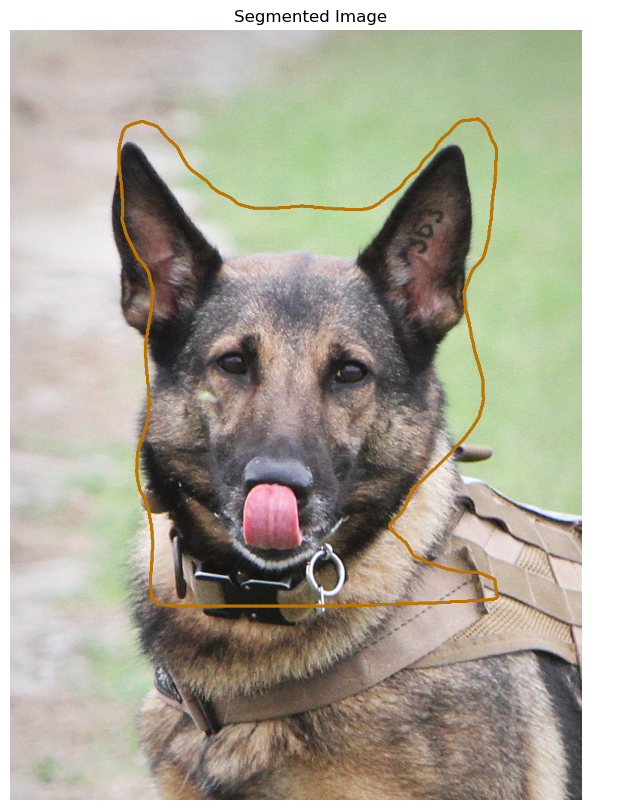

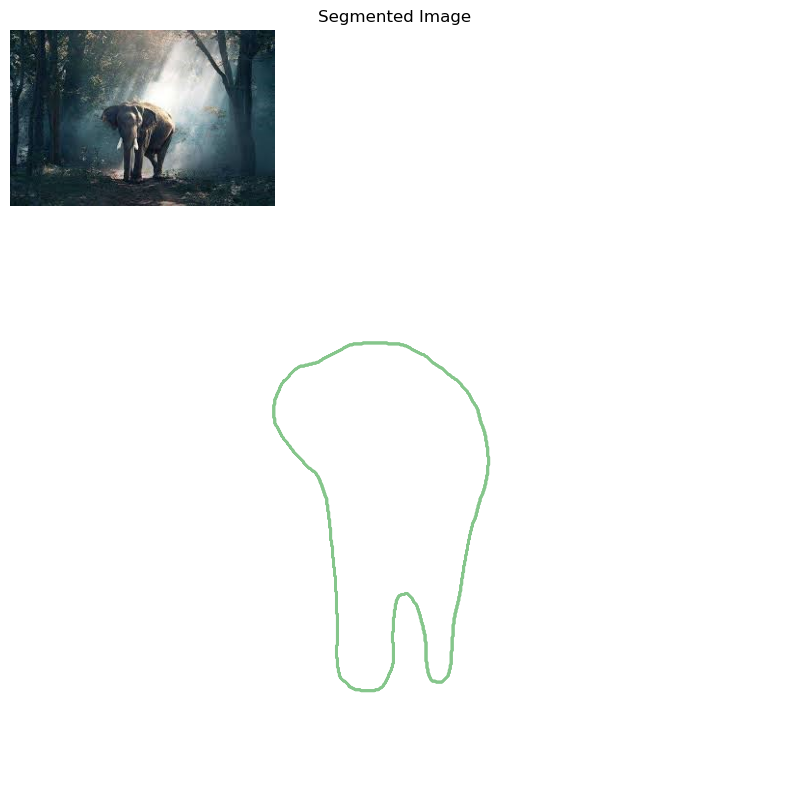

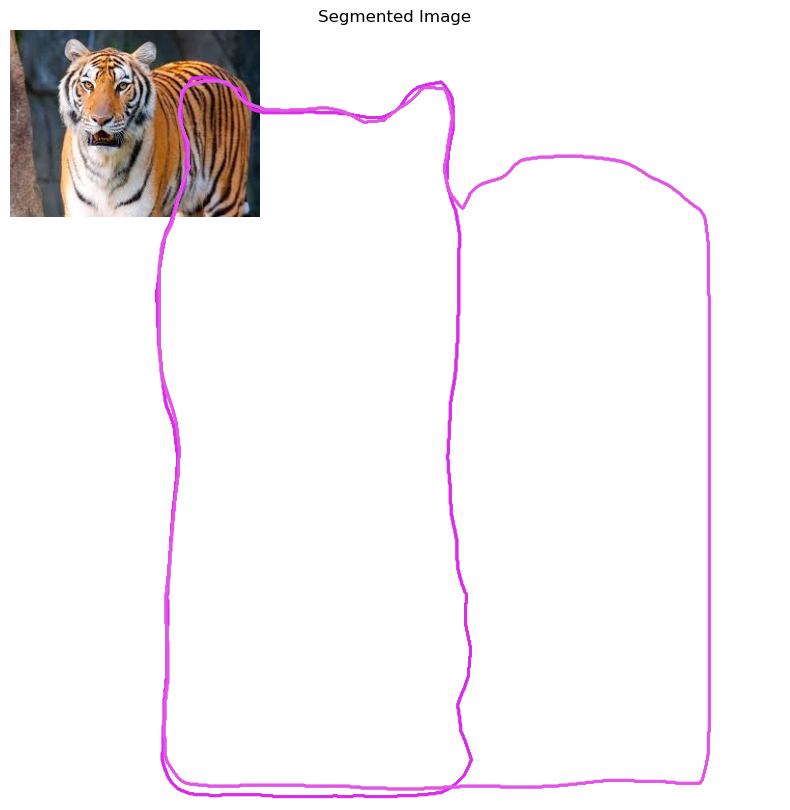

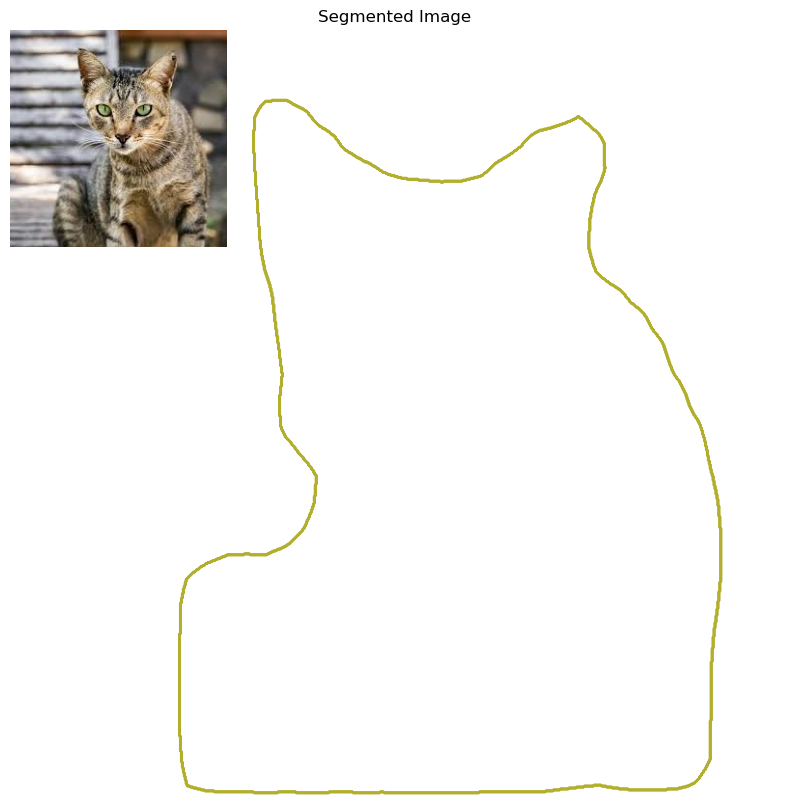

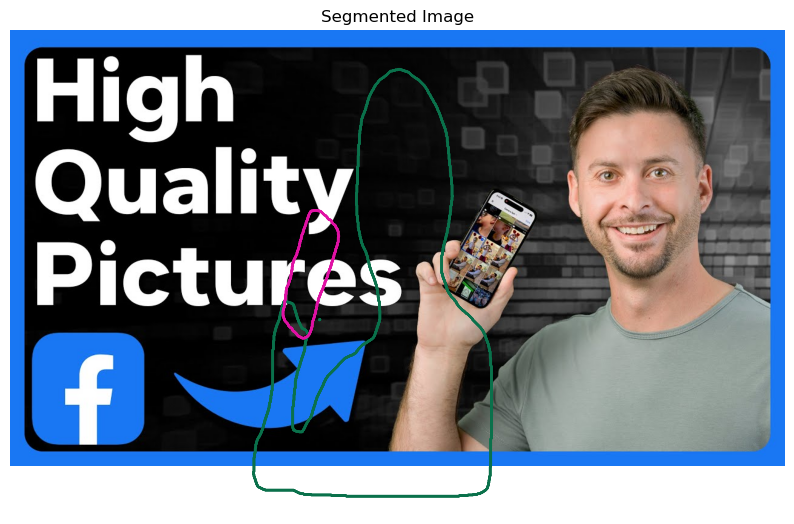

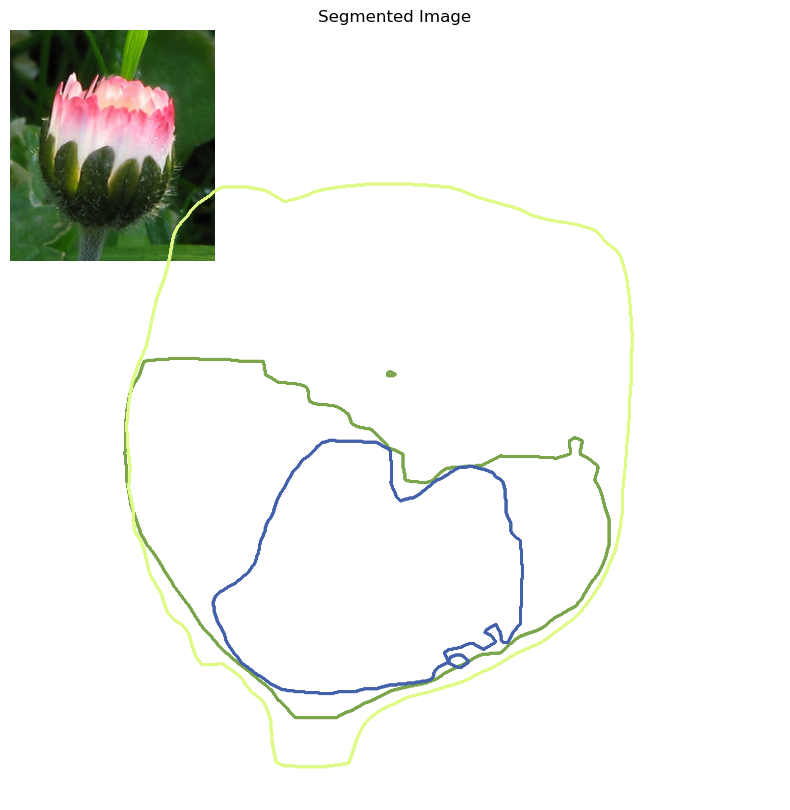

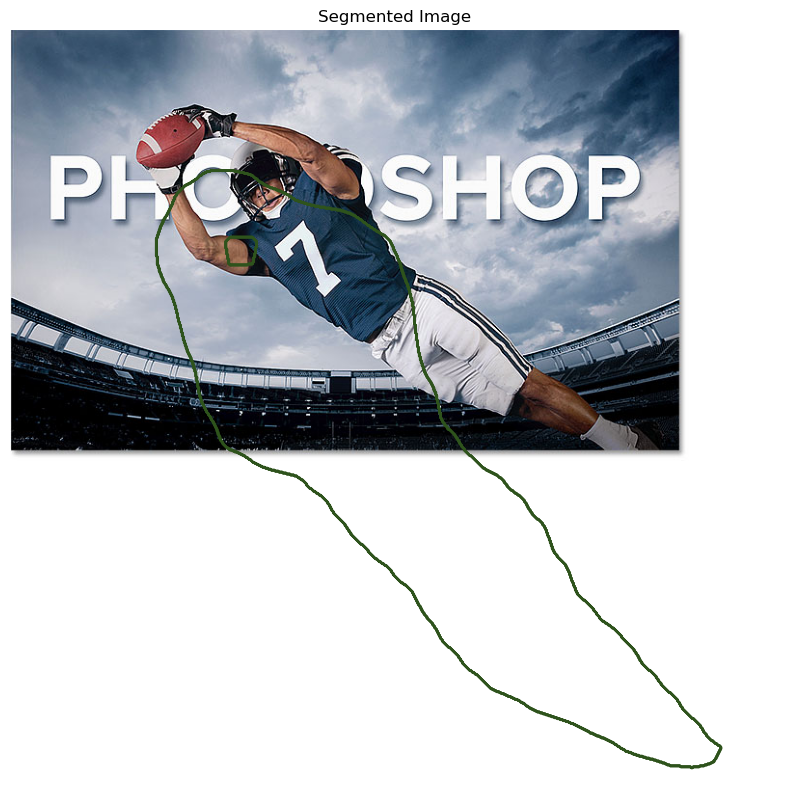

In [16]:
# Postprocess and visualize segmentation
def postprocess_image(image_tensor):
    image_np = image_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)
    image_np = (image_np * 255).astype(np.uint8)
    return image_np

def segment_image(image_path):
    image_tensor = preprocess_image(image_path, device)
    with torch.no_grad():
        prediction = model(image_tensor)
    
    masks = prediction[0]['masks'].cpu().numpy()
    labels = prediction[0]['labels'].cpu().numpy()
    scores = prediction[0]['scores'].cpu().numpy()
    
    original_image = cv2.imread(image_path)
    original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(original_image_rgb)
    
    for i in range(len(masks)):
        if scores[i] > 0.5:
            mask = masks[i, 0]
            mask = (mask > 0.5).astype(np.uint8)
            plt.contour(mask, colors=[np.random.rand(3,)])
    
    plt.title('Segmented Image')
    plt.axis('off')
    plt.show()

# Process each image
for image_file in image_files:
    image_path = os.path.join(input_images_dir, image_file)
    segment_image(image_path)


- Designd incorporate a model to segment objects inside an input image. This involves employing the Mask R-CNN model to segment or draw a bounding box around various objects in the image.

- Model Implementation: Used a model Mask R-CNN to process the image and identify segmented regions for each object.

- Code Output: Developed code to read an image, apply the segmentation model, and generate segmented regions.

- Visual Output: Display the original images with overlaid segmented objects to visually verify the segmentation results.

# 2. Object Extraction and Storage

Each extracted object should be assigned a unique ID for tracking

In [17]:
import pandas as pd
import cv2
import os
import numpy as np
import torch
from torchvision.transforms import functional as F

# Define directories
segmented_objects_dir = 'data/segmented_objects'
metadata_file = 'data/metadata.csv'

def extract_and_save_objects(image_path, master_id):
    # Load the original image
    original_image = cv2.imread(image_path)
    if original_image is None:
        raise ValueError(f"Failed to load image: {image_path}")
    original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    original_height, original_width, _ = original_image_rgb.shape
# Process All Images and Save Metadata
    # Preprocess the image
    image_tensor = preprocess_image(image_path, device)

    with torch.no_grad():
        prediction = model(image_tensor)

    masks = prediction[0]['masks'].cpu().numpy()
    labels = prediction[0]['labels'].cpu().numpy()
    scores = prediction[0]['scores'].cpu().numpy()

    # Create output directory if it doesn't exist
    os.makedirs(segmented_objects_dir, exist_ok=True)

    metadata = []
    object_id = 1

    for i in range(len(masks)):
        if scores[i] > 0.5:
            mask = masks[i, 0]
            mask = (mask > 0.5).astype(np.uint8)
            # Resize mask to match original image size
            mask_resized = cv2.resize(mask, (original_width, original_height))
            masked_image = np.zeros_like(original_image_rgb)
            masked_image[mask_resized == 1] = original_image_rgb[mask_resized == 1]

            # Save the object image
            object_file_path = os.path.join(segmented_objects_dir, f'{master_id}_{object_id}.jpg')
            cv2.imwrite(object_file_path, cv2.cvtColor(masked_image, cv2.COLOR_RGB2BGR))

            # Append metadata
            metadata.append({
                'master_id': master_id,
                'object_id': object_id,
                'file_path': object_file_path
            })
            object_id += 1

    return metadata

# Process all images
all_metadata = []
for image_file in os.listdir(input_images_dir):
    if image_file.endswith(('.jpg', '.jpeg', '.png')):
        image_path = os.path.join(input_images_dir, image_file)
        master_id = os.path.splitext(image_file)[0]
        metadata = extract_and_save_objects(image_path, master_id)
        all_metadata.extend(metadata)

# Save metadata to CSV
metadata_df = pd.DataFrame(all_metadata)
metadata_df.to_csv(metadata_file, index=False)

print(f"Extraction and storage complete. Metadata saved to {metadata_file}.")


Extraction and storage complete. Metadata saved to data/metadata.csv.


identification results saved to both .json and .csv format

# 3. Object Identification

### Loading and Setting Up CLIP Model

In [18]:
import os
import torch
import clip
from PIL import Image
import pandas as pd
import json

# Define directories
segmented_objects_dir = 'data/segmented_objects'
descriptions_file = 'data/descriptions.csv'
descriptions_json_file = 'data/descriptions.json'

# Define textual descriptions
descriptions = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train',
                'truck', 'boat', 'traffic light', 'fire hydrant', 'flower', 'stop sign', 
                'mobile phone', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 
                'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'lion', 'backpack', 
                'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 
                'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 
                'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 
                'knife', 'spoon', 'tiger', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 
                'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 
                'potted plant', 'bed', 'dining table', 'toilet', 'TV', 'laptop', 'mouse', 
                'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 
                'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 
                'hair drier', 'toothbrush']

# Load CLIP model and preprocess
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

### Object Identification Function

In [19]:
def identify_and_describe_object(image_path):
    # Load and preprocess the image
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    
    # Prepare the text inputs for CLIP
    text_inputs = clip.tokenize(descriptions).to(device)
    
    # Get the image and text features
    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text_inputs)
        
        # Calculate similarity between image and text features
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        
    # Get the top description
    top_description = descriptions[similarity[0].argmax().item()]
    return top_description

### Processing and saving Segmented Objects

In [20]:
# Process all segmented objects
metadata_file = 'data/metadata.csv'
metadata_df = pd.read_csv(metadata_file)
all_descriptions = []

for _, row in metadata_df.iterrows():
    object_image_path = row['file_path']
    description = identify_and_describe_object(object_image_path)
    
    # Append description to the metadata
    all_descriptions.append({
        'master_id': row['master_id'],
        'object_id': row['object_id'],
        'file_path': object_image_path,
        'description': description
    })

# Save descriptions to CSV
descriptions_df = pd.DataFrame(all_descriptions)
descriptions_df.to_csv(descriptions_file, index=False)

# Save descriptions to JSON
with open(descriptions_json_file, 'w') as json_file:
    json.dump(all_descriptions, json_file, indent=4)

print(f"Object identification complete. Descriptions saved to {descriptions_file} and {descriptions_json_file}.")

Object identification complete. Descriptions saved to data/descriptions.csv and data/descriptions.json.


# 4. Text/Data Extraction from Objects

### Setup

In [21]:
import os
import cv2
import easyocr

# Define directories
input_images_dir = 'data/input_images'
text_extraction_results_file_csv = 'data/text_extraction_results.csv'
text_extraction_results_file_json = 'data/text_extraction_results.json'

# Initialize EasyOCR reader
reader = easyocr.Reader(['en'])

# Function to extract text from an image
def extract_text(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to load image: {image_path}")
    results = reader.readtext(image)
    return results

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


### Text Extraction

In [22]:
import pandas as pd

# Prepare list to store results
results_list = []

# Get list of object image files
image_files = [f for f in os.listdir(input_images_dir) if os.path.isfile(os.path.join(input_images_dir, f))]

# Extract text/data from each image
for image_file in image_files:
    image_path = os.path.join(input_images_dir, image_file)
    try:
        results = extract_text(image_path)
        
        # Process the results and store them in the list
        for (bbox, text, prob) in results:
            bbox = [[float(coord) for coord in point] for point in bbox]  # Convert bbox coordinates to float
            prob = float(prob)  # Ensure confidence is a float
            
            results_list.append({
                'Image': image_file,
                'BBox': bbox,
                'Text': text,
                'Confidence': prob
            })
    except Exception as e:
        print(f"Error processing {image_file}: {e}")


### Saving Results

In [23]:
import json

# Convert list to DataFrame
results_df = pd.DataFrame(results_list)

# Save results to CSV file
results_df.to_csv(text_extraction_results_file_csv, index=False)
print(f"Saved text extraction results to {text_extraction_results_file_csv}")

# Save results to JSON file
try:
    with open(text_extraction_results_file_json, 'w') as json_file:
        json.dump(results_list, json_file, indent=4)
    print(f"Saved text extraction results to {text_extraction_results_file_json}")
except TypeError as e:
    print(f"Failed to save JSON results: {e}")


Saved text extraction results to data/text_extraction_results.csv
Saved text extraction results to data/text_extraction_results.json


# 5. Summarize Object Attributes

### Setup

In [24]:
import pandas as pd
import json
import os
import csv

# Define file paths
identification_results_file = 'data/descriptions.csv'
text_extraction_results_file = 'data/text_extraction_results.csv'
summary_results_file = 'data/summaries.csv'
summary_results_json_file = 'data/summaries.json'

# Load identification and text extraction results with error handling
try:
    identification_df = pd.read_csv(identification_results_file, encoding='utf-8', error_bad_lines=False, quoting=csv.QUOTE_MINIMAL)
    text_extraction_df = pd.read_csv(text_extraction_results_file, encoding='utf-8', error_bad_lines=False, quoting=csv.QUOTE_MINIMAL)
except Exception as e:
    print(f"Error loading CSV files: {e}")
    raise

# Print column names for debugging
print("Identification DataFrame columns:", identification_df.columns)
print("Text Extraction DataFrame columns:", text_extraction_df.columns)

# Print sample rows for debugging
print("Sample rows from identification DataFrame:")
print(identification_df.head())
print("Sample rows from text extraction DataFrame:")
print(text_extraction_df.head())

# Extract filenames from file paths in identification_df
identification_df['Image'] = identification_df['file_path'].apply(lambda x: os.path.basename(x))

Identification DataFrame columns: Index(['master_id', 'object_id', 'file_path', 'description'], dtype='object')
Text Extraction DataFrame columns: Index(['Image', 'BBox', 'Text', 'Confidence'], dtype='object')
Sample rows from identification DataFrame:
  master_id  object_id                             file_path description
0   image_1          1  data/segmented_objects\image_1_1.jpg         dog
1   image_2          1  data/segmented_objects\image_2_1.jpg    elephant
2   image_3          1  data/segmented_objects\image_3_1.jpg       tiger
3   image_3          2  data/segmented_objects\image_3_2.jpg       tiger
4   image_4          1  data/segmented_objects\image_4_1.jpg         cat
Sample rows from text extraction DataFrame:
         Image                                               BBox      Text  \
0  image_5.jpg  [[28.0, 26.0], [388.0, 26.0], [388.0, 200.0], ...      High   
1  image_5.jpg  [[27.0, 162.0], [580.0, 162.0], [580.0, 351.0]...   Quality   
2  image_5.jpg  [[35.0, 337.

C:\Users\Rahul\AppData\Local\Temp\ipykernel_25504\394609724.py:14: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  identification_df = pd.read_csv(identification_results_file, encoding='utf-8', error_bad_lines=False, quoting=csv.QUOTE_MINIMAL)
C:\Users\Rahul\AppData\Local\Temp\ipykernel_25504\394609724.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  text_extraction_df = pd.read_csv(text_extraction_results_file, encoding='utf-8', error_bad_lines=False, quoting=csv.QUOTE_MINIMAL)


### Merging and Summarizing Data

In [25]:
# Check if required columns are present
required_id_columns = ['master_id', 'object_id', 'Image', 'description']
required_text_columns = ['Image', 'BBox', 'Text', 'Confidence']

for col in required_id_columns:
    if col not in identification_df.columns:
        print(f"Warning: Missing column in identification results: {col}")

for col in required_text_columns:
    if col not in text_extraction_df.columns:
        print(f"Warning: Missing column in text extraction results: {col}")

# Merge results on 'Image' column
merged_df = pd.merge(identification_df, text_extraction_df, on='Image', how='left')

# Create summary DataFrame
summary_df = pd.DataFrame(columns=['master_id', 'object_id', 'file_path', 'description', 'BBox', 'Text', 'Confidence'])

# Generate summaries
for _, row in merged_df.iterrows():
    summary_df = summary_df.append({
        'master_id': row['master_id'],
        'object_id': row['object_id'],
        'file_path': row['file_path'],
        'description': row['description'],
        'BBox': row.get('BBox', 'N/A'),  # Default to 'N/A' if NaN
        'Text': row.get('Text', 'N/A'),  # Default to 'N/A' if NaN
        'Confidence': row.get('Confidence', 'N/A')  # Default to 'N/A' if NaN
    }, ignore_index=True)

C:\Users\Rahul\AppData\Local\Temp\ipykernel_25504\4219987423.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append({
C:\Users\Rahul\AppData\Local\Temp\ipykernel_25504\4219987423.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append({
C:\Users\Rahul\AppData\Local\Temp\ipykernel_25504\4219987423.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append({
C:\Users\Rahul\AppData\Local\Temp\ipykernel_25504\4219987423.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append({
C:\Users\Rahul\AppData\Local\Temp\ipykernel_25504\421998

### Saving Results

In [26]:
# Save summary results to CSV
summary_df.to_csv(summary_results_file, index=False)
print(f"Saved summary results to {summary_results_file}")

# Save summary results to JSON
summary_json = summary_df.to_dict(orient='records')
with open(summary_results_json_file, 'w') as json_file:
    json.dump(summary_json, json_file, indent=4)
print(f"Saved summary results to {summary_results_json_file}")

Saved summary results to data/summaries.csv
Saved summary results to data/summaries.json


# 6. Data Mapping

### Load Data and Prepare for Merging

In [27]:
import pandas as pd
import json
import os

# Define file paths
identification_results_file = 'data/descriptions.csv'
text_extraction_results_file = 'data/text_extraction_results.csv'

# Load identification and text extraction results
try:
    identification_df = pd.read_csv(identification_results_file)
    text_extraction_df = pd.read_csv(text_extraction_results_file)
except Exception as e:
    print(f"Error loading CSV files: {e}")
    raise

# Extract base filenames from the file paths for matching
identification_df['Base_Image'] = identification_df['file_path'].apply(lambda x: os.path.basename(x).split('_')[0])
text_extraction_df['Base_Image'] = text_extraction_df['Image'].apply(lambda x: x.split('_')[0])

print("Data loaded and base filenames extracted.")

Data loaded and base filenames extracted.


### Merge DataFrames and Prepare for Mapping

In [28]:
# Merge on base image names
merged_df = pd.merge(identification_df, text_extraction_df, on='Base_Image', how='left')

# Check merged DataFrame
print("Merged DataFrame with base image names:")
print(merged_df.head(10))

# Create data mapping structure
data_mapping = []
for master_id, group in merged_df.groupby('master_id'):
    object_details = []
    for _, row in group.iterrows():
        item = {
            'object_id': row['object_id'],
            'file_path': row['file_path'],
            'description': row['description'],
            'text_data': {
                'BBox': row.get('BBox', 'N/A'),  # Use 'N/A' for missing values
                'Text': row.get('Text', 'N/A'),
                'Confidence': row.get('Confidence', 'N/A')
            }
        }
        object_details.append(item)
    
    data_mapping.append({
        'master_id': master_id,
        'object_details': object_details
    })

print("Data mapping structure prepared.")

Merged DataFrame with base image names:
  master_id  object_id                             file_path description  \
0   image_1          1  data/segmented_objects\image_1_1.jpg         dog   
1   image_1          1  data/segmented_objects\image_1_1.jpg         dog   
2   image_1          1  data/segmented_objects\image_1_1.jpg         dog   
3   image_1          1  data/segmented_objects\image_1_1.jpg         dog   
4   image_1          1  data/segmented_objects\image_1_1.jpg         dog   
5   image_1          1  data/segmented_objects\image_1_1.jpg         dog   
6   image_2          1  data/segmented_objects\image_2_1.jpg    elephant   
7   image_2          1  data/segmented_objects\image_2_1.jpg    elephant   
8   image_2          1  data/segmented_objects\image_2_1.jpg    elephant   
9   image_2          1  data/segmented_objects\image_2_1.jpg    elephant   

  Base_Image        Image                                               BBox  \
0      image  image_5.jpg  [[28.0, 26.0], [

### Save Data Mapping to JSON in a output 

In [29]:
# Define output file path
data_mapping_file = 'data/output/data_mapping.json'

# Ensure the output directory exists
output_dir = os.path.dirname(data_mapping_file)
os.makedirs(output_dir, exist_ok=True)

# Save data mapping to JSON
with open(data_mapping_file, 'w') as json_file:
    json.dump({"images": data_mapping}, json_file, indent=4)

print(f"Saved data mapping to {data_mapping_file}")

Saved data mapping to data/output/data_mapping.json


# 7.output generation

### Setup and Data Loading

In [30]:
import pandas as pd
import json
import os

# Define file paths
data_mapping_file = 'data/output/data_mapping.json'
summary_results_file = 'data/summaries.csv'
original_images_folder = 'data/input_images/'
output_dir = 'data/output/table_and_annotated/'

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Load data
with open(data_mapping_file, 'r') as json_file:
    data_mapping = json.load(json_file)['images']

summary_df = pd.read_csv(summary_results_file)

### Plotting Function

In [31]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image

def plot_image_with_annotations(image_path, objects, output_path):
    try:
        img = Image.open(image_path)
    except FileNotFoundError:
        print(f"Image not found: {image_path}")
        return
    
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img)

    for obj in objects:
        bbox_data = obj['text_data']['BBox']
        # Plot bounding boxes if they exist and are valid
        if pd.notna(bbox_data) and bbox_data not in ['N/A', 'NaN']:
            try:
                bbox = json.loads(bbox_data)  # Convert from JSON string
                if isinstance(bbox, list) and len(bbox) == 4:
                    x_min, y_min, x_max, y_max = bbox[0][0], bbox[0][1], bbox[2][0], bbox[2][1]
                    rect = Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                     linewidth=2, edgecolor='red', facecolor='none')
                    ax.add_patch(rect)
                    # Annotate with text and confidence
                    annotation_text = f"{obj['description']} ({obj['text_data']['Text']})"
                    plt.text(x_min, y_min - 10, annotation_text,
                             bbox=dict(facecolor='yellow', alpha=0.5), fontsize=8, color='black')
                else:
                    print(f"Invalid BBox format for object {obj['object_id']} in {obj['file_path']}: {bbox}")
            except (json.JSONDecodeError, KeyError, IndexError) as e:
                print(f"Error parsing BBox for object {obj['object_id']} in {obj['file_path']}: {e}")

    plt.axis('off')
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.close()


### Summary Table Generation Function

In [32]:
def generate_summary_table(objects, csv_output_path, json_output_path):
    summary_data = []
    for obj in objects:
        summary_data.append({
            'Object ID': obj['object_id'],
            'File Path': obj['file_path'],
            'Description': obj['description'],
            'BBox': obj['text_data']['BBox'],
            'Text': obj['text_data']['Text'],
            'Confidence': obj['text_data']['Confidence']
        })
    
    summary_df = pd.DataFrame(summary_data)
    
    # Save as CSV
    summary_df.to_csv(csv_output_path, index=False)
    print(f"Saved summary table to CSV: {csv_output_path}")
    
    # Save as JSON
    with open(json_output_path, 'w') as json_file:
        json.dump(summary_data, json_file, indent=4)
    print(f"Saved summary table to JSON: {json_output_path}")


### Main Processing Loop

In [33]:
# Generate output for each master image
for entry in data_mapping:
    master_id = entry['master_id']
    objects = entry['object_details']
    
    # Extract base image name
    base_image_name = f"{master_id}.jpg"
    original_image_path = os.path.join(original_images_folder, base_image_name)
    
    # Output paths
    annotated_image_path = os.path.join(output_dir, f"annotated_{base_image_name}")
    summary_table_csv_path = os.path.join(output_dir, f"summary_{master_id}.csv")
    summary_table_json_path = os.path.join(output_dir, f"summary_{master_id}.json")
    
    # Check if the original image exists
    if not os.path.exists(original_image_path):
        print(f"Image not found: {original_image_path}")
        continue
    
    # Plot the image with annotations
    plot_image_with_annotations(original_image_path, objects, annotated_image_path)
    
    # Generate and save the summary table in both CSV and JSON formats
    generate_summary_table(objects, summary_table_csv_path, summary_table_json_path)

print(f"Annotated images and summary tables saved in {output_dir}")


Saved summary table to CSV: data/output/table_and_annotated/summary_image_1.csv
Saved summary table to JSON: data/output/table_and_annotated/summary_image_1.json
Saved summary table to CSV: data/output/table_and_annotated/summary_image_2.csv
Saved summary table to JSON: data/output/table_and_annotated/summary_image_2.json
Saved summary table to CSV: data/output/table_and_annotated/summary_image_3.csv
Saved summary table to JSON: data/output/table_and_annotated/summary_image_3.json
Saved summary table to CSV: data/output/table_and_annotated/summary_image_4.csv
Saved summary table to JSON: data/output/table_and_annotated/summary_image_4.json
Saved summary table to CSV: data/output/table_and_annotated/summary_image_5.csv
Saved summary table to JSON: data/output/table_and_annotated/summary_image_5.json
Saved summary table to CSV: data/output/table_and_annotated/summary_image_6.csv
Saved summary table to JSON: data/output/table_and_annotated/summary_image_6.json
Saved summary table to CSV: 